# Linear regression (global features) vs Gaussian kernel regression (local kernels) in 1D

This notebook is designed for teaching the intuition behind **kernel regression** and the **kernel trick**.

## Key idea

### Linear regression with hand-designed features (primal view)
We pick a feature map / basis functions $\phi_j(x)$ (e.g., polynomial features) and fit linear coefficients, $\beta$:
$$
f(x)=\sum_{j=0}^{p-1} \beta_j\,\phi_j(x)
$$

The basis functions can be *local* (only non-zero for a finite domain of $x$ values) or *global* (non-zero almost everywhere).

If the basis functions are *global* (like $1,x,x^2,\dots$), changing one coefficient affects the function across the whole input range.

### Kernel regression (dual view + kernel trick)
Many regularized kernel methods (e.g., kernel ridge regression) end up with a solution of the form:
$$
f(x)=\sum_{i=1}^{n} \alpha_i\,k(x,x_i)
$$
So instead of a small set of fixed basis functions, we have **one basis function per training point**.  
For a **Gaussian/RBF kernel**,
$$
k(x,x_i)=\exp\!\left(-\frac{(x-x_i)^2}{2\sigma^2}\right),
$$
each term is a **localized bump** around $x_i$. The fitted function is the **sum of weighted bumps**.

> Important nuance: locality depends on the *kernel choice*.  
> Gaussian/RBF is local; polynomial kernels are global.

Run the cells below to generate a 1D dataset and compare:
1) **polynomial regression** (global basis contributions), and  
2) **Gaussian kernel ridge regression** (local kernel contributions).

x_train: [-2.968 -1.649 -1.329 -1.199 -1.182 -0.192  0.751  1.654  1.782  1.927
  2.241  2.383]
y_train: [-0.75  -1.466 -1.241 -1.067 -1.363 -0.298  0.547  1.134  1.058  1.287
  1.042  1.205]


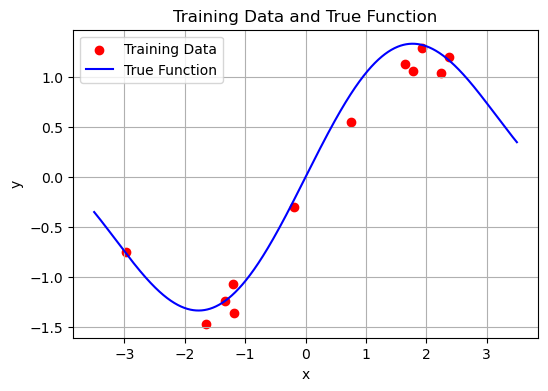

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Generate a simple 1D dataset ---
rng = np.random.default_rng(7)
n = 12
x_train = np.sort(rng.uniform(-3, 3, size=n))
y_true = np.sin(x_train) + 0.2*x_train
y_train = y_true + rng.normal(0, 0.15, size=n)

# Grid for plotting
x = np.linspace(-3.5, 3.5, 1200)

print("x_train:", np.round(x_train, 3))
print("y_train:", np.round(y_train, 3))

# Plot the training data
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, color='red', label='Training Data')
plt.plot(x, np.sin(x) + 0.2*x, color='blue', label='True Function')
plt.title('Training Data and True Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

## Part A — Linear regression with a global basis (polynomial features)

We fit:
$$
f(x)=\sum_{i=0}^{d} \beta_i x^i.
$$
Then we plot each **weighted basis contribution** $\beta_i x^i$ and their **sum**.

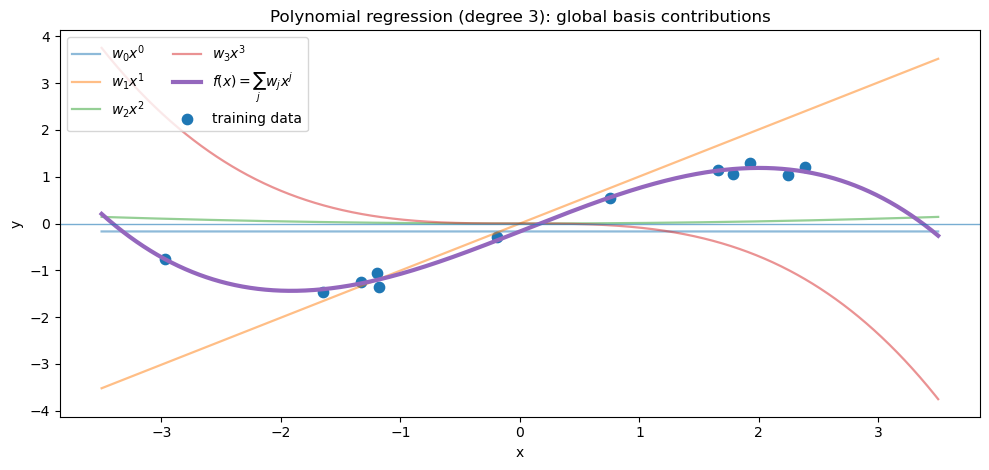

Polynomial coefficients w: [-0.1694  1.006   0.0116 -0.0876]


In [2]:
# --- Polynomial regression (global basis) ---
deg = 3  # try changing this (e.g., 1, 3, 7)

# Design matrix for training points: [1, x, x^2, ..., x^deg]
X_poly = np.vstack([x_train**d for d in range(deg+1)]).T

# Least squares fit
w, *_ = np.linalg.lstsq(X_poly, y_train, rcond=None)

# Basis contributions on grid
Phi_grid = np.vstack([x**d for d in range(deg+1)])           # (deg+1, len(x))
contribs_poly = (w[:, None] * Phi_grid)                      # (deg+1, len(x))
f_poly = contribs_poly.sum(axis=0)

plt.figure(figsize=(10, 4.8))
for j in range(deg+1):
    plt.plot(x, contribs_poly[j], linewidth=1.6, alpha=0.5, label=rf"$w_{j}x^{j}$")
plt.plot(x, f_poly, linewidth=3.0, label=r"$f(x)=\sum_j w_j x^j$")
plt.scatter(x_train, y_train, s=55, marker="o", label="training data")
plt.axhline(0, linewidth=1.0, alpha=0.6)

plt.title(f"Polynomial regression (degree {deg}): global basis contributions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="upper left", frameon=True, ncol=2)
plt.tight_layout()
plt.show()

print("Polynomial coefficients w:", np.round(w, 4))

### Note on global behavior

- Each basis function $x^i$ is nonzero almost everywhere.
- Changing a single coefficient $\beta_i$ changes the prediction across the whole $x$-axis.
- This is not “good or bad” — it’s a modeling choice.
- An example of a *local* basis are splines, which are still fit by linear regression.

## Part B — Gaussian kernel ridge regression (one local kernel per training point)

Kernel ridge regression solves:
$$
\min_\alpha \|K\alpha-y\|^2 + \lambda\,\alpha^\top K\,\alpha,
$$
with solution:
$$
\alpha = (K+\lambda I)^{-1}y,
$$
where $K_{ij}=k(x_i,x_j)$.

Prediction:
$$
f(x)=\sum_i \alpha_i\,k(x,x_i)
$$
We plot each **local weighted kernel** $\alpha_i k(x,x_i)$ and their **sum**.

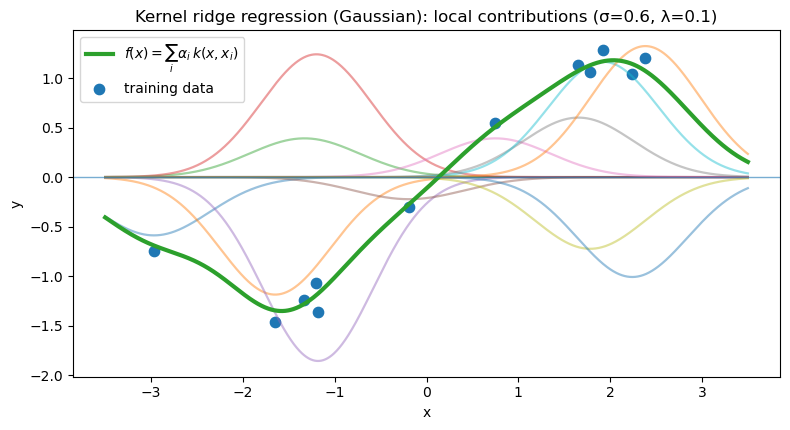

alpha coefficients: [-0.5889 -1.1874  0.3914  1.2406 -1.858  -0.2232  0.3913  0.601  -0.7245
  1.1645 -1.0095  1.3238]


In [3]:
def rbf_kernel(xa, xb, sigma):
    xa = np.asarray(xa)[:, None]
    xb = np.asarray(xb)[None, :]
    return np.exp(-0.5*((xa-xb)/sigma)**2)

sigma = 0.6   # kernel width (controls locality)
lam   = 1e-1  # ridge regularization

K = rbf_kernel(x_train, x_train, sigma)
alpha = np.linalg.solve(K + lam*np.eye(n), y_train)

# Evaluate contributions on grid
K_grid = rbf_kernel(x, x_train, sigma)            # (len(x), n)
contribs_krr = (K_grid * alpha[None, :])          # (len(x), n): each column is alpha_i k(x,x_i)
f_krr = contribs_krr.sum(axis=1)

plt.figure(figsize=(8, 4.4))
for i in range(n):
    plt.plot(x, contribs_krr[:, i], linewidth=1.6, alpha=0.45, label="_nolegend_")
plt.plot(x, f_krr, linewidth=3.0, label=r"$f(x)=\sum_i \alpha_i\,k(x,x_i)$")
plt.scatter(x_train, y_train, s=55, marker="o", label="training data")
plt.axhline(0, linewidth=1.0, alpha=0.6)

plt.title(rf"Kernel ridge regression (Gaussian): local contributions (σ={sigma}, λ={lam})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="upper left", frameon=True)
plt.tight_layout()
plt.show()

print("alpha coefficients:", np.round(alpha, 4))

### Note on local behavior

For the Gaussian kernel,
- $k(x,x_i)\approx 1$ when $x$ is close to $x_i$,
- $k(x,x_i)\to 0$ as you move away from $x_i$.

So the $i$-th term $\alpha_i k(x,x_i)$ is mostly influential near $x_i$.  
The full predictor is the sum of these localized effects.

> The influence is **not exactly zero** far away (Gaussian has infinite support), but it decays rapidly.

## Part C — (Optional) Interactive sliders (if ipywidgets is installed)

Install `ipywidgets` to interactively change:
- polynomial degree,
- Gaussian width $\sigma$,
- ridge $\lambda$.

If this cell errors, just ignore it and use the static plots above.

In [4]:
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    def plot_all(deg=3, sigma=0.6, lam=1e-1):
        clear_output(wait=True)

        # --- Polynomial fit ---
        X_poly = np.vstack([x_train**d for d in range(deg+1)]).T
        w, *_ = np.linalg.lstsq(X_poly, y_train, rcond=None)
        Phi_grid = np.vstack([x**d for d in range(deg+1)])
        contribs_poly = (w[:, None] * Phi_grid)
        f_poly = contribs_poly.sum(axis=0)

        plt.figure(figsize=(7, 3))
        for j in range(deg+1):
            plt.plot(x, contribs_poly[j], linewidth=1.4, alpha=0.5, label=rf"$w_{j}x^{j}$")
        plt.plot(x, f_poly, linewidth=3.0, label=r"$f(x)=\sum_j w_j x^j$")
        plt.scatter(x_train, y_train, s=45, marker="o", label="training data")
        plt.axhline(0, linewidth=1.0, alpha=0.6)
        plt.title(f"Polynomial regression (degree {deg}): global contributions")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend(loc="upper left", frameon=True, ncol=2)
        plt.tight_layout()
        plt.show()

        # --- Kernel ridge fit ---
        K = rbf_kernel(x_train, x_train, sigma)
        alpha = np.linalg.solve(K + lam*np.eye(n), y_train)
        K_grid = rbf_kernel(x, x_train, sigma)
        contribs_krr = (K_grid * alpha[None, :])
        f_krr = contribs_krr.sum(axis=1)

        plt.figure(figsize=(7, 3))
        for i in range(n):
            plt.plot(x, contribs_krr[:, i], linewidth=1.4, alpha=0.45, label="_nolegend_")
        plt.plot(x, f_krr, linewidth=3.0, label=r"$f(x)=\sum_i \alpha_i k(x,x_i)$")
        plt.scatter(x_train, y_train, s=45, marker="o", label="training data")
        plt.axhline(0, linewidth=1.0, alpha=0.6)
        plt.title(rf"Kernel ridge (Gaussian): local contributions (σ={sigma:.2f}, λ={lam:.1e})")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend(loc="upper left", frameon=True)
        plt.tight_layout()
        plt.show()

    deg_slider = widgets.IntSlider(value=3, min=1, max=12, step=1, description='degree')
    sigma_slider = widgets.FloatSlider(value=0.6, min=0.15, max=2.0, step=0.05, description='sigma')
    lam_slider = widgets.FloatLogSlider(value=1e-1, base=10, min=-6, max=0, step=1, description='lambda')

    ui = widgets.VBox([deg_slider, sigma_slider, lam_slider])
    out = widgets.interactive_output(plot_all, {'deg': deg_slider, 'sigma': sigma_slider, 'lam': lam_slider})

    display(ui, out)

except Exception as e:
    print("ipywidgets not available (or not running in a widget-enabled environment).")
    print("Error:", e)

Output()